In [1]:
import random
import numpy as np
import pandas as pd

In [2]:
from IPython.display import clear_output
from tqdm import tqdm

In [3]:
from typing import Dict, List, Tuple
from buffer_pool_baseline.timer import Time
from buffer_pool_baseline.cache import Cache
from buffer_pool_baseline.strategy import EvictionStrategy


class Query:
    def __init__(self, query_type: str, parameters: Dict, cache: Cache = None, time: Time = None,
                 found_in_cache_optim=True):
        self.query_type = query_type
        self.parameters = parameters
        self.time = time

        self.cache = cache
        self.done = False

        self.found_in_cache_optim = found_in_cache_optim
        self.hits = 0
        self.misses = 0
        self.actions = ["lru", "mru"]

    def copy(self):
        q = Query(self.query_type, self.parameters, self.cache.copy(), self.time.copy())
        q.done = self.done
        q.found_in_cache_optim = self.found_in_cache_optim
        q.hits = self.hits
        q.misses = self.misses
        return q

    def set_query_cache(self, cache):
        self.cache = cache

    def set_time(self, time):
        self.time = time

    def is_done(self):
        return self.done

    def step(self, action=None):
        if self.is_done():
            return self.hits, self.misses

        self.time.increment()
        hits, misses, found_in_cache = None, None, None

        if self.query_type == "select":
            hits, misses, found_in_cache = self._step_select_query(action)

        if self.query_type == "join":
            hits, misses, found_in_cache = self._step_join_query(action)

        if self.query_type == "sequential":
            hits, misses, found_in_cache = self._step_sequential_query(action)

        # If the optimizer is on, continue steos
        if found_in_cache and self.found_in_cache_optim:
            self.step(action)

        return hits, misses

    def _get_element(self, value, action):
        next_element = self.cache.get_element_by_id(value)
        found_in_cache = False

        if next_element:
            # Increase the hit rate if element is found!
            self.hits += 1
            found_in_cache = True
        else:
            self.cache.add_element(value, action)
            self.misses += 1

        next_element = self.cache.get_element_by_id(value)
        return next_element, found_in_cache

    def _step_select_query(self, action=None):
        # parameter requirement: {"start": int, "end": int}
        if self.parameters.get("current_position") is None:
            self.parameters["current_position"] = self.parameters["start"]

        if self.parameters["current_position"] == self.parameters["end"]:
            self.done = True
            return self.hits, self.misses, False

        next_element, found_in_cache = self._get_element(self.parameters["current_position"], action)
        next_element.get_value()

        # Increment the current position
        self.parameters["current_position"] += 1

        return self.hits, self.misses, found_in_cache

    def _step_sequential_query(self, action = None):
        if self.parameters.get("current_position") is None:
            self.parameters["current_position"] = self.parameters["start"]

        if self.parameters.get("current_counter") is None:
            self.parameters["current_counter"] = 0

        if self.parameters["current_position"] == self.parameters["end"] and \
                self.parameters["current_counter"] == self.parameters["loop_size"]:
            self.done = True
            return self.hits, self.misses, False

        if self.parameters["current_position"] == self.parameters["end"]:
            current_element, found_in_cache = self._get_element(self.parameters["current_position"], action)
            current_element.get_value()

            self.parameters["current_counter"] += 1
            self.parameters["current_position"] = self.parameters["start"]

            return self.hits, self.misses, found_in_cache

        current_element, found_in_cache = self._get_element(self.parameters["current_position"], action)
        current_element.get_value()

        self.parameters["current_position"] += 1

        return self.hits, self.misses, found_in_cache

    def _step_join_query(self, action=None):
        # parameter requirement: {"start_table_1": int, "end_table_1": int,
        # start_table_2": int, "end_table_2": int}
        if self.parameters.get("current_position_table_1") is None:
            self.parameters["current_position_table_1"] = self.parameters["start_table_1"]

        if self.parameters.get("current_position_table_2") is None:
            self.parameters["current_position_table_2"] = self.parameters["start_table_2"]

        if (self.parameters["current_position_table_1"] == self.parameters["end_table_1"]) and \
                (self.parameters["current_position_table_2"] == self.parameters["end_table_2"]):
            # Query is complete
            self.done = True
            return self.hits, self.misses, False

        if self.parameters["current_position_table_2"] == self.parameters["end_table_2"]:
            # Reset the values for the next iteration
            self.parameters["current_position_table_1"] += 1
            self.parameters["current_position_table_2"] = self.parameters["start_table_2"]

        # Get both the elements!
        element_1, found_in_cache_1 = self._get_element(self.parameters["current_position_table_1"], action)
        element_1.get_value()

        element_2, found_in_cache_2 = self._get_element(self.parameters["current_position_table_2"], action)
        element_2.get_value()
        self.parameters["current_position_table_2"] += 1

        return self.hits, self.misses, (found_in_cache_1 and found_in_cache_2)

In [4]:
%matplotlib inline

In [5]:
q_table = np.zeros([1000, 2])
cache_size = 4

In [6]:
def setup():
    t = Time(0)
    
    c = Cache(cache_size, t, equate_id_to_value=True)
    
    start = random.randint(0, 20)
    end = start + 5
    loop_size = random.randint(1, 3)
    
    env = Query(query_type="sequential", time=t, parameters={"start": start, "end": end, "loop_size": loop_size})
    env.set_query_cache(c)
    
    c.add_element(random.randint(0, 30))
    c.add_element(random.randint(0, 30))
    c.add_element(random.randint(0, 30))
    c.add_element(random.randint(0, 30))
    return env

In [7]:
def get_query(query_type, table_size, loop_size):
    t = Time()
    if query_type == "sequential":
        return Query(query_type="sequential", time=t, parameters={"start": 0, "end": table_size, "loop_size": loop_size})
    
    if query_type == "select":
        return Query(query_type="select", time=t, parameters={"start": 0, "end": table_size})
    
    if query_type == "join":
        return Query(query_type="join", time=t, parameters={"start_table_1": 0, "end_table_1": 10, 
                                                            "start_table_2": 0, "end_table_2": 10})
    

In [8]:
def get_time_steps_per_query(table_size, cache_size, loop_size):
    time_steps = {}
    
    query_types = ["sequential", "select", "join"]
    
    for query in query_types:
        t = Time(0)
        env = get_query(query, table_size, loop_size)
        c = Cache(cache_size, t, equate_id_to_value=True)
        env.set_query_cache(c)

        while not env.is_done():
            env.step("mru")

        time_steps[query] = env.time.now()
    
    return time_steps

In [9]:
def encode_queries(query_type, time_step, max_time_steps):
    return max_time_steps[query_type] + time_step

In [10]:
max_time_steps = get_time_steps_per_query(10, 4, 5)

In [11]:
alpha = 0.0001
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

In [12]:
q_values_cumulative = []
old_q = np.zeros([1000, 2])

In [13]:
number_of_runs = 10**8

In [14]:
cum_reward_plot = []

for i in tqdm(range(1, number_of_runs)):
    
    env = setup()
    state = encode_queries(env.query_type, env.time.now(), max_time_steps)
    
    penalties, reward, = 0, 0
    done = False
    previous_hit, previous_miss = 0, 0
    cum_reward = 0
    tm = 0
    old_q = q_table.copy()
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            action = random.choice(env.actions) # Explore action space
        else:
            _action_ = np.argmax(q_table[state]) # Exploit learned values
            action = "mru" if _action_ == 0 else "lru"
            
        hits, miss = env.step(action)
        next_state = encode_queries(env.query_type, env.time.now(), max_time_steps)
        
        reward = hits - previous_hit
        penalties =miss - previous_miss
        
        previous_hit = hits
        previous_miss = miss
        
        done = env.done

        _action_ = 0 if action == "mru" else 1
        
        old_value = q_table[state, _action_]
        next_max = np.max(q_table[next_state])
        
        r = reward - penalties
        new_value = (1 - alpha) * old_value + alpha * (r + gamma * next_max)
        q_table[state, _action_] = new_value
        state = next_state
        cum_reward += r
        tm += 1
    q_values_cumulative.append({"q_values_cumulative": sum(sum(abs(old_q - q_table)))})
    cum_reward_plot.append({"reward": cum_reward, "epoch": i, "time": tm})

print("Training finished.\n")

#Can we normalize reward update somehow?

100%|█████████████████████████████████████████████████████████████████| 99999999/99999999 [20:01:06<00:00, 1387.61it/s]


Training finished.



In [15]:
df_q_value = pd.DataFrame(q_values_cumulative)
df_q_value.head()

,q_values_cumulative
0,0.0011
1,0.0013
2,0.0011
3,0.0017
4,0.0009


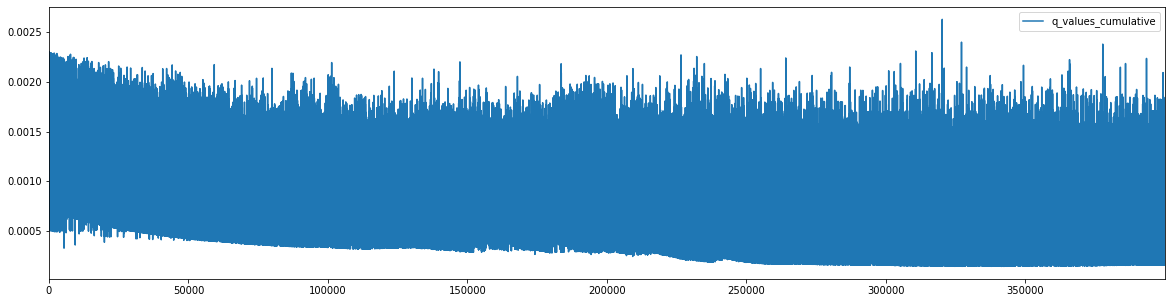

In [75]:
df_q_value.head(400000).plot(figsize=(20,5))

In [17]:
max_time_steps

{'sequential': 66, 'select': 11, 'join': 111}

In [18]:
def evaluate_policy(query, q_table):
    cache_map_policy = []
    
    start_index = max_time_steps[query.query_type]
    
    reward = 0
    
    for d in q_table[start_index:]:
        action = ["mru", "lru"][np.argmax(d)]
        cache_map_policy.append({"action": action, 
                                 "cache": query.cache.cache_map.copy().keys(),
                                "which_element": query.parameters.copy()})
        query.step(action)
        
        if query.is_done():
            break
    
    hits, misses = query.step()
    reward = hits -  misses
    return hits, misses
    

In [19]:
def get_baseline(query, action = "mru"):
    cache_map_baseline = []
    
    while not query.is_done():
        query.step(action)
        cache_map_baseline.append({"cache": query.cache.cache_map.copy().keys(), 
                                   "which_element": query.parameters.copy()})
        
    hits, misses = query.step()
    return hits, misses

In [20]:
def compare_reward():
    
    env = setup()
    params_baseline = env.parameters.copy()
    params_random = env.parameters.copy()
    params_policy = env.parameters.copy()
    
    t = Time(0)
    query_baseline = Query(query_type="sequential", parameters=params_baseline, time=t)
    c = Cache(cache_size, time=t, equate_id_to_value=True)
    query_baseline.set_query_cache(c)
    
    query_baseline_random = Query(query_type="sequential", parameters=params_random, time=t)
    c2 = Cache(cache_size, time=t, equate_id_to_value=True)
    query_baseline_random.set_query_cache(c2)
    
    query_policy = Query(query_type="sequential", parameters=params_policy, time=t)
    c3 = Cache(cache_size, time=t, equate_id_to_value=True)
    query_policy.set_query_cache(c3)
    
    hits_policy, misses_policy = evaluate_policy(query_policy, q_table)
    hits_baseline, misses_baseline = get_baseline(query_baseline)
    hits_random, misses_random = get_baseline(query_baseline_random, "random")
    
    return {"hits_random" : hits_random, "misses_random": misses_random, 
            "hits_baseline": hits_baseline, "misses_baseline": misses_baseline,
           "hits_policy": hits_policy, "misses_policy": misses_policy}

In [21]:
compare_reward()

{'hits_random': 5,
 'misses_random': 18,
 'hits_baseline': 11,
 'misses_baseline': 12,
 'hits_policy': 9,
 'misses_policy': 14}

In [22]:
results = []

for i in range(1000):
    res = compare_reward()
    results.append(res)

In [23]:
df_results = pd.DataFrame(results)

In [24]:
df_results["reward_policy"] = df_results["hits_policy"] - df_results["misses_policy"]
df_results["reward_random"] = df_results["hits_random"] - df_results["misses_random"]
df_results["reward_baseline"] = df_results["hits_baseline"] - df_results["misses_baseline"]

In [25]:
df_results

,hits_random,misses_random,hits_baseline,misses_baseline,hits_policy,misses_policy,reward_policy,reward_random,reward_baseline
0,4,19,11,12,9,14,-5,-15,-1
1,6,11,7,10,5,12,-7,-5,-3
2,3,8,3,8,2,9,-7,-5,-5
3,5,12,7,10,5,12,-7,-7,-3
4,2,9,3,8,2,9,-7,-7,-5
...,...,...,...,...,...,...,...,...,...
995,3,8,3,8,2,9,-7,-5,-5
996,4,13,7,10,5,12,-7,-9,-3
997,2,9,3,8,2,9,-7,-7,-5
998,8,15,11,12,9,14,-5,-7,-1


In [37]:
df = pd.DataFrame(cum_reward_plot)
df.head()

MemoryError: 

In [27]:
df["r"] = df["reward"] / df["time"]
df.head()

,reward,epoch,time,r
0,-11,1,12,-0.916667
1,-11,2,15,-0.733333
2,-11,3,12,-0.916667
3,-9,4,17,-0.529412
4,-7,5,10,-0.700000


In [28]:
df["reward"] = (df["reward"]-df["reward"].mean())/df["reward"].std()

In [29]:
df["rolling_mean"] = df["r"].rolling(window=200).mean()

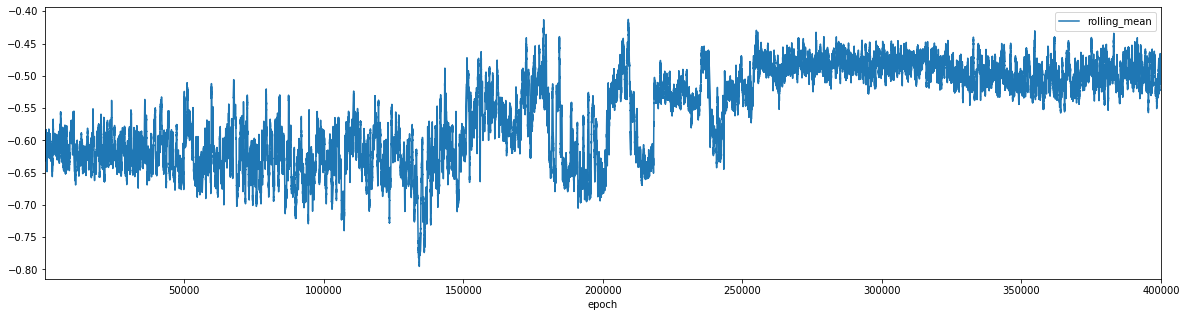

In [74]:
df.head(400000).plot(y="rolling_mean", x="epoch",figsize=(20,5))

In [ ]:
len(df)

In [51]:
result = "Results/runs_{}_alpha_{}_gamma_{}_cache_{}.csv".format(number_of_runs, alpha, gamma, cache_size)

In [53]:
df.to_csv(result)

In [61]:
import pickle

In [36]:
pickle.dump( q_table, open( "q_table.p", "wb" ) )

In [49]:
pickle.dump( q_values_cumulative, open( "q_values_cumulative.p", "wb" ) )

MemoryError: 

In [54]:
df_q_value.to_csv(result)

In [47]:
del(cum_reward_plot)

In [62]:
q_values_cumulative=pickle.load( open( "q_values_cumulative.p", "rb" ) )

EOFError: Ran out of input

In [63]:
whos

Variable                   Type                     Data/Info
-------------------------------------------------------------
Cache                      type                     <class 'buffer_pool_baseline.cache.Cache'>
Dict                       _GenericAlias            typing.Dict
EvictionStrategy           type                     <class 'buffer_pool_basel<...>rategy.EvictionStrategy'>
List                       _GenericAlias            typing.List
Query                      type                     <class '__main__.Query'>
Time                       type                     <class 'buffer_pool_baseline.timer.Time'>
Tuple                      _VariadicGenericAlias    typing.Tuple
action                     str                      mru
all_epochs                 list                     n=0
all_penalties              list                     n=0
alpha                      float                    0.0001
cache_size                 int                      4
clear_output               f

In [84]:
q_table_df=pd.DataFrame(q_table)[66:111]

In [90]:
(q_table_df[0]>=q_table_df[1])

66      True
67     False
68      True
69     False
70      True
71     False
72     False
73      True
74      True
75     False
76      True
77      True
78      True
79      True
80      True
81      True
82      True
83      True
84      True
85      True
86     False
87      True
88      True
89      True
90      True
91      True
92      True
93      True
94      True
95      True
96      True
97      True
98      True
99      True
100     True
101     True
102     True
103     True
104     True
105     True
106     True
107     True
108     True
109     True
110     True
dtype: bool

In [83]:
max_time_steps

{'sequential': 66, 'select': 11, 'join': 111}

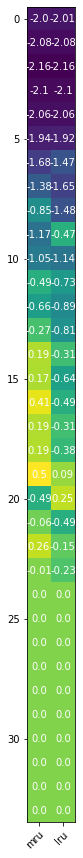

In [121]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

farmers = ["mru", "lru"]
fig, ax = plt.subplots()
im = ax.imshow(q_table[66:100])

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
#ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
#ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(q_table[66:100])):
    for j in range(len(farmers)):
        #print(q_table[66+i, j])
        text = ax.text(j, i, round(q_table[66+i, j],2),
                       ha="center", va="center", color="w")
fig.set_figheight(15)
fig.set_figwidth(20)
#ax.set_title("Harvest of local farmers (in tons/year)")
plt.show()
#Copy to clipboard

In [112]:
q_table[66:100]

array([[-2.00405987, -2.01093252],
       [-2.08318766, -2.08268152],
       [-2.1634448 , -2.16459748],
       [-2.09653872, -2.09633327],
       [-2.05578109, -2.0562265 ],
       [-1.93888079, -1.92107127],
       [-1.68001837, -1.46662838],
       [-1.37709646, -1.6483655 ],
       [-0.84781307, -1.48280139],
       [-1.16516348, -0.46660039],
       [-1.05429269, -1.14304866],
       [-0.48579832, -0.72683329],
       [-0.66440885, -0.89452371],
       [-0.27334842, -0.81099164],
       [ 0.18618924, -0.314488  ],
       [ 0.17126992, -0.64415447],
       [ 0.40572407, -0.49149508],
       [ 0.18602669, -0.30582203],
       [ 0.19259885, -0.37612909],
       [ 0.50381119,  0.09186156],
       [-0.4885628 ,  0.24566512],
       [-0.06153804, -0.49299864],
       [ 0.2620262 , -0.15232501],
       [-0.00592389, -0.22790293],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

In [99]:
harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])

In [100]:
harvest.shape

(7, 7)